<a href="https://colab.research.google.com/github/bramantyo-source/Hacktiv-IBM-Project-Post/blob/main/Hacktiv_Data_Sesi_3_Rafael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.74
    Uninstalling langchain-core-0.3.74:
      Successfully uninstalled langchain-core-0.3.74
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB

In [ ]:
!pip -q install -U langchain langchain-community "replicate>=1.0.7" openpyxl

from google.colab import userdata
import os, getpass

token = userdata.get("api_token")
if not token:
    raise ValueError("Secret 'api_token' tidak ditemukan di Colab Secrets.")
os.environ["REPLICATE_API_TOKEN"] = token


In [ ]:
from langchain_community.llms import Replicate

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"max_new_tokens": 120, "temperature": 0.3}
)

print(llm.invoke("Tulis 2 kalimat ringkasan tentang indikator kesehatan Ibu & Anak Tangsel 2022."))


Kalimat ringkasan 1: Indeks Kesehatan Ibu & Anak (IKA) Tangerang Selatan 2022 menunjukkan perkembangan positif dengan peningkatan persentase anak lahir sihat, tetapi tingginya kematian ibu dan anak masih menjadi masalah utama.

Kalimat ringkasan 2: IKA Tangerang Selatan 2022 mencatat peningkatan jumlah anak lahir sihat, namun kematian ibu dan anak tetap menjadi perhatian karena angka yang lebih tinggi dibandingkan dengan tahun sebelumnya.


In [ ]:
from google.colab import files
import zipfile, os, shutil, re
import pandas as pd

uploaded = files.upload()              # pilih ZIP kamu
zip_path = next(iter(uploaded.keys()))
work_dir, clean_dir = "/content/_in", "/content/_clean"
shutil.rmtree(work_dir, ignore_errors=True); shutil.rmtree(clean_dir, ignore_errors=True)
os.makedirs(work_dir, exist_ok=True); os.makedirs(clean_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(work_dir)

print("Diekstrak ke:", work_dir)


Saving Data_set.zip to Data_set.zip
Diekstrak ke: /content/_in


In [ ]:
import os, re
import pandas as pd
from functools import reduce

work_dir = "/content/_in"   # folder hasil ekstrak ZIP
cleaned = []

# --- utils ---
def read_csv_robust(path):
    # deteksi delimiter otomatis, fallback ke ';' dan latin-1
    for enc in ["utf-8", "latin-1"]:
        try:
            return pd.read_csv(path, header=None, dtype=str, sep=None, engine="python", encoding=enc)
        except Exception:
            try:
                return pd.read_csv(path, header=None, dtype=str, sep=";", engine="python", encoding=enc)
            except Exception:
                continue
    raise

def slug(s):
    s = re.sub(r"[^0-9A-Za-z]+", "_", str(s)).strip("_")
    return s.lower()[:40]

def make_unique(cols):
    seen = {}
    out = []
    for c in cols:
        c = "" if c is None else str(c).strip()
        if c == "" or c.lower() == "nan":
            c = "col"
        if c in seen:
            seen[c] += 1
            out.append(f"{c}.{seen[c]}")
        else:
            seen[c] = 0
            out.append(c)
    return out

def to_numeric_series(s):
    s = s.astype(str).str.replace("%","", regex=False).str.strip()
    # jika banyak koma -> anggap koma desimal (EU style)
    if s.str.contains(",", na=False).mean() > 0.3:
        s = s.str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    else:
        s = s.str.replace(",", "", regex=False)
    return pd.to_numeric(s, errors="coerce")

def clean_table(df, prefix):
    # cari header yg mengandung 'Kecamatan' di 30 baris pertama
    hdr = None
    for i in range(min(30, len(df))):
        row = df.iloc[i].astype(str).str.strip()
        if row.str.contains(r"(?i)\bkecamatan\b", na=False, regex=True).any():
            hdr = i; break

    if hdr is not None:
        cols = make_unique(df.iloc[hdr].tolist())
        df = df.iloc[hdr+1:].copy()
        df.columns = cols
    else:
        df.columns = make_unique(df.iloc[0].tolist())
        df = df.iloc[1:].copy()

    # buang kosong & 'Unnamed'
    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
    df = df.loc[:, [c for c in df.columns if not str(c).startswith("Unnamed")]]
    df.columns = [str(c).strip() for c in df.columns]

    # pastikan ada kolom Kecamatan
    kec_col = next((c for c in df.columns if re.search(r"(?i)\bkecamatan\b", c)), None)
    if not kec_col:
        return None
    if kec_col != "Kecamatan":
        df = df.rename(columns={kec_col: "Kecamatan"})

    # trim isi sel
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()

    # konversi numerik untuk selain 'Kecamatan'
    for c in [c for c in df.columns if c != "Kecamatan"]:
        df[c] = to_numeric_series(df[c])

    # beri prefix unik berdasarkan file/sheet
    rename = {c: f"{prefix}__{slug(c)}" for c in df.columns if c != "Kecamatan"}
    df = df.rename(columns=rename)

    # urutan & filter
    df = df[df["Kecamatan"].notna() & (df["Kecamatan"].astype(str).str.len() > 0)]
    df = df[["Kecamatan"] + [c for c in df.columns if c != "Kecamatan"]]
    return df

# --- baca semua file & bersihkan ---
for root, _, files in os.walk(work_dir):
    for fn in files:
        path = os.path.join(root, fn)
        base = slug(os.path.splitext(fn)[0])
        try:
            if fn.lower().endswith(".xlsx"):
                xls = pd.read_excel(path, sheet_name=None, header=None, dtype=str)
                for sheet, d in xls.items():
                    pref = f"{base}__{slug(sheet)}"
                    dfc = clean_table(d, prefix=pref)
                    if dfc is not None: cleaned.append(dfc)
                    else: print(f"[SKIP] {fn} | sheet {sheet}: kolom 'Kecamatan' tidak ketemu")
            elif fn.lower().endswith(".csv"):
                d = read_csv_robust(path)
                pref = base
                dfc = clean_table(d, prefix=pref)
                if dfc is not None: cleaned.append(dfc)
                else: print(f"[SKIP] {fn}: kolom 'Kecamatan' tidak ketemu")
            else:
                print(f"[SKIP] {fn} (bukan CSV/XLSX)")
        except Exception as e:
            print(f"[SKIP] {fn}: {e}")

# --- merge outer berdasarkan 'Kecamatan' ---
if cleaned:
    master = reduce(lambda L, R: pd.merge(L, R, on="Kecamatan", how="outer"), cleaned)
    # sedikit dedupe jaga-jaga kalau masih ada tabrakan nama
    master.columns = make_unique(master.columns)
    master_path = "/content/master_dataset_clean.csv"
    master.to_csv(master_path, index=False)
    print("Master shape:", master.shape)
    print("Saved:", master_path)
else:
    print("Tidak ada tabel valid yang ditemukan.")



Master shape: (10, 40)
Saved: /content/master_dataset_clean.csv


In [ ]:
# === Sanity Check v2: deteksi kolom persentase yang benar ===
import re, numpy as np, pandas as pd

PATH = "/content/master_dataset_clean.csv"
df = pd.read_csv(PATH)
assert "Kecamatan" in df.columns, "Kolom 'Kecamatan' wajib ada."

# ---- helper: apakah seri tampak seperti persen (>=95% nilai 0..100 dan max <= 100.5)
def is_pct_series(series: pd.Series, tol_max=100.5, min_ratio_in_range=0.95) -> bool:
    x = pd.to_numeric(series, errors="coerce").dropna()
    if x.empty:
        return False
    return (x.between(0, 100).mean() >= min_ratio_in_range) and (x.max() <= tol_max)

# ---- kandidat berdasar nama (kecuali yang mirip count)
name_candidates = [
    c for c in df.columns if c != "Kecamatan"
    and re.search(r"(persentase|prevalensi|stunting|imunisasi|asi|anemia|malnutr|dasar_lengkap|coverage|cakupan|%)", c, re.I)
    and not re.search(r"\b(jumlah|total)\b", c, re.I)
]

# ---- kelompokkan kolom dengan pola root__col, root__col_1, dst
pattern = re.compile(r"^(.*?)(__col(?:_\d+)?)$")
groups = {}
for c in df.columns:
    if c == "Kecamatan":
        continue
    m = pattern.match(c)
    root = m.group(1) if m else c
    groups.setdefault(root, []).append(c)

# ---- pilih kolom persen valid
pct_cols = set()
for root, cols in groups.items():
    # buang yang jelas count
    cols = [c for c in cols if not re.search(r"\b(jumlah|total|sdmk|tenaga|nutrisionis|dietisien|panjang_badan)\b", c, re.I)]
    for c in cols:
        if is_pct_series(df[c]):
            pct_cols.add(c)

pct_cols.update(name_candidates)
pct_cols = [c for c in pct_cols if not re.search(r"\b(jumlah|total)\b", c, re.I)]

# ---- laporkan kolom out-of-range (seharusnya 0..100)
out_of_range = []
for c in pct_cols:
    x = pd.to_numeric(df[c], errors="coerce")
    bad = x[~x.between(0, 100)].dropna()
    if not bad.empty:
        out_of_range.append(c)

print("✅ Kolom persen terdeteksi (max 12):", pct_cols[:12])
print("⚠️ Out-of-range (harus 0–100):", out_of_range if out_of_range else "N/A")
print("OK ✅ | shape:", df.shape)

# (opsional) simpan daftar kolom persen untuk tahap berikutnya
pd.Series(pct_cols, name="percent_columns").to_csv("/content/_percent_columns.txt", index=False)
print("📄 Disimpan: /content/_percent_columns.txt")



✅ Kolom persen terdeteksi (max 12): ['26a_prevalensi_stunting_malnutrisi_anemi__col_3', '24_jumlah_balita_menurut_panjang_badan_d__col_2', '26a_prevalensi_stunting_malnutrisi_anemi__col', '1a_jumlah_dan_persentase_penanganan_bali__col_1', '6a_jumlah_pelayanan_dan_perawatan_bayi_m__col_8', '14a_jumlah_dan_persentase_balita_yang_me__col_1', '11a_jumlah_dan_persentase_ibu_hamil_mend__col', '24a_jumlah_dan_persentase_anak_umur_12_2__col_1', '1a_jumlah_dan_persentase_penanganan_bali__col_2', '26a_prevalensi_stunting_malnutrisi_anemi__col_2', '25a_jumlah_dan_persentase_bayi_usia_kura__col', '25a_jumlah_dan_persentase_bayi_usia_kura__col_2']
⚠️ Out-of-range (harus 0–100): ['11a_jumlah_dan_persentase_ibu_hamil_mend__col', '24a_jumlah_dan_persentase_anak_umur_12_2__col_1', '25a_jumlah_dan_persentase_bayi_usia_kura__col', '13a_persentase_bayi_baru_lahir_yang_mend__col_1', '13a_persentase_bayi_baru_lahir_yang_mend__col', '25a_jumlah_dan_persentase_bayi_usia_kura__col_1', '24a_jumlah_dan_persentas

In [ ]:
# === FINALISASI: validasi persen -> PRIORITY_SCORE -> save -> AI summary ===
import re, json, numpy as np, pandas as pd, os

PATH = "/content/master_dataset_clean.csv"
df = pd.read_csv(PATH)
assert "Kecamatan" in df.columns, "Kolom 'Kecamatan' wajib ada."

# --- Ambil kandidat kolom persen dari file sebelumnya
pct_cols_path = "/content/_percent_columns.txt"
if os.path.exists(pct_cols_path):
    pct_cols = pd.read_csv(pct_cols_path, header=None).iloc[:,0].tolist()
else:
    pct_cols = [c for c in df.columns if re.search(r"(persentase|prevalensi|stunting|imunisasi|asi|anemia|malnutr|cakupan|coverage|%)", c, re.I)]

# --- Filter: buang kolom yang jelas COUNT, lalu keep yang >=95% nilai 0..100
def valid_pct(series: pd.Series, min_ratio=0.95):
    x = pd.to_numeric(series, errors="coerce").dropna()
    return (len(x)>0) and (x.between(0,100).mean() >= min_ratio)

EXCLUDE = re.compile(r"\b(jumlah|total|sdmk|tenaga|nutrisionis|dietisien|panjang_badan|jumlah_balita)\b", re.I)
pct_cols = [c for c in pct_cols if (c in df.columns) and not EXCLUDE.search(c) and valid_pct(df[c])]

# Bersihkan nilai di luar 0..100 -> NaN
for c in pct_cols:
    x = pd.to_numeric(df[c], errors="coerce")
    x[~x.between(0,100)] = np.nan
    df[c] = x

# --- Pilih kolom inti (pakai regex paling umum)
def pick(regex):
    for c in pct_cols:
        if re.search(regex, c, re.I): return c
    return None

col_stunting  = pick(r"stunting|prevalen")
col_imunisasi = pick(r"imunisasi|dasar_lengkap|anak.?12")
col_asi       = pick(r"\basi\b|bayi(?!.*(jumlah|total))")

layanan_pct_cols = [c for c in pct_cols if re.search(r"(pelayanan|perawatan|ibu|bayi|balita)", c, re.I)]

# Tenaga gizi = COUNT (bukan persen)
gizi_cols = [c for c in df.columns if re.search(r"(sdmk|tenaga|nutrisionis|dietisien)", c, re.I)]
if gizi_cols:
    df[gizi_cols] = df[gizi_cols].apply(pd.to_numeric, errors="coerce")
    df["TenagaGizi_Total"] = df[gizi_cols].sum(axis=1, min_count=1)
else:
    df["TenagaGizi_Total"] = np.nan

# --- Hitung PRIORITY_SCORE
def pctl(s): return s.rank(pct=True, method="average")

parts = []
if col_stunting:
    df["risk_stunting"]  = pctl(df[col_stunting]);                parts.append(("risk_stunting", 0.40))
if col_imunisasi:
    df["risk_imunisasi"] = 1 - pctl(df[col_imunisasi]);           parts.append(("risk_imunisasi", 0.20))
if col_asi:
    df["risk_asi"]       = 1 - pctl(df[col_asi]);                 parts.append(("risk_asi", 0.20))
if layanan_pct_cols:
    df["risk_layanan"]   = 1 - pctl(df[layanan_pct_cols].mean(axis=1)); parts.append(("risk_layanan", 0.15))
if "TenagaGizi_Total" in df:
    df["risk_gizi_staff"]= 1 - pctl(df["TenagaGizi_Total"]);      parts.append(("risk_gizi_staff", 0.05))

w_sum = sum(w for _,w in parts) if parts else 1.0
df["PRIORITY_SCORE"] = np.nansum([df[k]*w for k,w in parts], axis=0)/w_sum

rank = df[["Kecamatan","PRIORITY_SCORE"]+[k for k,_ in parts]].sort_values("PRIORITY_SCORE", ascending=False)

# --- Save
master_out = "/content/master_dataset_clean.csv"  # overwrite dengan persen yang sudah dibersihkan
rank_out   = "/content/priority_ranking.csv"
facts_out  = "/content/facts_for_ai.json"

df.to_csv(master_out, index=False)
rank.to_csv(rank_out, index=False)

facts = {}
if col_stunting:
    facts["top_stunting"]  = df.nlargest(3, col_stunting)[["Kecamatan", col_stunting]].values.tolist()
    facts["mean_stunting"] = round(pd.to_numeric(df[col_stunting], errors="coerce").mean(skipna=True),2)
if col_imunisasi:
    facts["low_imunisasi"] = df.nsmallest(3, col_imunisasi)[["Kecamatan", col_imunisasi]].values.tolist()
    facts["mean_imunisasi"]= round(pd.to_numeric(df[col_imunisasi], errors="coerce").mean(skipna=True),2)
if col_asi:
    facts["low_asi"]       = df.nsmallest(3, col_asi)[["Kecamatan", col_asi]].values.tolist()
    facts["mean_asi"]      = round(pd.to_numeric(df[col_asi], errors="coerce").mean(skipna=True),2)

with open(facts_out, "w", encoding="utf-8") as f:
    json.dump(facts, f, ensure_ascii=False, indent=2)

print("✅ Disimpan:")
print(" - Master (clean):", master_out, df.shape)
print(" - Ranking       :", rank_out)
print(" - Facts JSON    :", facts_out)
print("\nKolom terpakai:")
print(" - Stunting   :", col_stunting)
print(" - Imunisasi  :", col_imunisasi)
print(" - ASI        :", col_asi)
print(" - Layanan(%) :", layanan_pct_cols[:5])

# --- (Opsional) Ringkasan otomatis via IBM Granite (Replicate)
try:
    import replicate
    if os.environ.get("REPLICATE_API_TOKEN") and facts:
        prompt = f"""
Anda adalah analis kesehatan. Tulis ringkasan ≤150 kata (Bahasa Indonesia)
berdasarkan fakta berikut (jangan menambah angka):
{json.dumps(facts, ensure_ascii=False)}

Instruksi:
- Sebutkan kecamatan dengan stunting tertinggi.
- Soroti imunisasi/ASI terendah (jika ada).
- Berikan 2–3 rekomendasi realistis.
- Gaya profesional, tanpa tabel.
"""
        out = llm = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={"prompt": prompt, "max_new_tokens": 220, "temperature": 0.25}
        )
        print("\n=== RINGKASAN AI ===\n" + "".join(out))
    else:
        print("\n(ℹ️ Lewati ringkasan AI: token tidak ada atau facts kosong.)")
except Exception as e:
    print("\n(⚠️ Ringkasan AI gagal:", e, ")")


✅ Disimpan:
 - Master (clean): /content/master_dataset_clean.csv (10, 46)
 - Ranking       : /content/priority_ranking.csv
 - Facts JSON    : /content/facts_for_ai.json

Kolom terpakai:
 - Stunting   : 26a_prevalensi_stunting_malnutrisi_anemi__col_3
 - Imunisasi  : None
 - ASI        : 6a_jumlah_pelayanan_dan_perawatan_bayi_m__col_8
 - Layanan(%) : ['24_jumlah_balita_menurut_panjang_badan_d__col_2', '6a_jumlah_pelayanan_dan_perawatan_bayi_m__col_8', '14a_jumlah_dan_persentase_balita_yang_me__col_1', '25a_jumlah_dan_persentase_bayi_usia_kura__col_2', '13a_persentase_bayi_baru_lahir_yang_mend__col_2']

=== RINGKASAN AI ===
Dari data yang diberikan, kecamatan Pamulang memiliki angka stunting terbesar dengan nilai 6.64, diikuti oleh Ciputat dengan nilai 6.22. Kecamatan Serpong memiliki angka stunting terendah dengan nilai 4.51. Imunisasi (ASI) paling rendah terjadi di Ciputat Timur, Pamulang, dan Serpong Utara, dengan nilai nol. Rata-rata ASI adalah 1.75.

Untuk mengatasi masalah stunting,

In [ ]:
# === PATCH: temukan kolom IMUNISASI & ASI yang benar, lalu hitung ulang ranking & facts ===
import re, json, numpy as np, pandas as pd, os

PATH = "/content/master_dataset_clean.csv"
df = pd.read_csv(PATH)
assert "Kecamatan" in df.columns, "Kolom 'Kecamatan' wajib ada."

# helper numeric checks
def frac_ratio(s):
    x = pd.to_numeric(s, errors="coerce").dropna()
    return 0 if x.empty else x.between(0, 1).mean()

def pct_ratio(s):
    x = pd.to_numeric(s, errors="coerce").dropna()
    return 0 if x.empty else x.between(0, 100).mean()

def pick_percent_from_candidates(cands, prefer_low_median=True, min_pct_ratio=0.6):
    # ambil hanya yang terlihat seperti persen 0..100
    cands_pct = [c for c in cands if pct_ratio(df[c]) >= min_pct_ratio]
    if cands_pct:
        if prefer_low_median:
            meds = {c: pd.to_numeric(df[c], errors="coerce").median(skipna=True) for c in cands_pct}
            return min(meds, key=meds.get)
        return cands_pct[0]
    # fallback: kalau 0..1, skala ke 0..100
    cands_frac = [c for c in cands if frac_ratio(df[c]) >= min_pct_ratio]
    if cands_frac:
        c = cands_frac[0]
        df[c] = pd.to_numeric(df[c], errors="coerce") * 100
        return c
    return None

# Kandidat IMUNISASI: biasanya dari file "24a_jumlah_dan_persentase_anak_umur_12-23..."
imun_cands = [c for c in df.columns if re.search(r"(imunisasi|12[_\- ]?2|12[_\-]?23)", c, re.I)]
# buang yang jelas COUNT
imun_cands = [c for c in imun_cands if not re.search(r"\b(jumlah|total|sdmk|tenaga|nutrisionis|dietisien)\b", c, re.I)]
col_imunisasi = pick_percent_from_candidates(imun_cands)

# Kandidat ASI eksklusif: biasanya dari file "25a_jumlah_dan_persentase_bayi_usia_kurang_dari_6_bulan_..._ASI"
asi_cands = [c for c in df.columns if re.search(r"(asi|bayi[_\- ]?usia[_\- ]?kura|kurang.*6.*bulan)", c, re.I)]
asi_cands = [c for c in asi_cands if not re.search(r"\b(pelayanan|perawatan|jumlah|total)\b", c, re.I)]
col_asi = pick_percent_from_candidates(asi_cands)

# Layanan (%) – ambil yang benar-benar tampak seperti persen & terkait layanan ibu/bayi/balita
layanan_pct_cols = [
    c for c in df.columns
    if re.search(r"(pelayanan|perawatan|ibu|bayi|balita)", c, re.I)
    and pct_ratio(df[c]) >= 0.8
    and not re.search(r"\b(jumlah|total)\b", c, re.I)
]

# Stunting – cari kolom prevalensi stunting yang valid 0..100
stunting_cands = [c for c in df.columns if re.search(r"(stunting|prevalen)", c, re.I)]
stunting_cands = [c for c in stunting_cands if pct_ratio(df[c]) >= 0.7]
col_stunting = pick_percent_from_candidates(stunting_cands)

# Tenaga gizi = COUNT
gizi_cols = [c for c in df.columns if re.search(r"(sdmk|tenaga|nutrisionis|dietisien)", c, re.I)]
if gizi_cols:
    df[gizi_cols] = df[gizi_cols].apply(pd.to_numeric, errors="coerce")
    df["TenagaGizi_Total"] = df[gizi_cols].sum(axis=1, min_count=1)
else:
    df["TenagaGizi_Total"] = np.nan

# Hitung ulang PRIORITY_SCORE
def pctl(s):
    return s.rank(pct=True, method="average")

parts = []
if col_stunting:
    df["risk_stunting"]  = pctl(pd.to_numeric(df[col_stunting], errors="coerce"))
    parts.append(("risk_stunting", 0.40))
if col_imunisasi:
    df["risk_imunisasi"] = 1 - pctl(pd.to_numeric(df[col_imunisasi], errors="coerce"))
    parts.append(("risk_imunisasi", 0.20))
if col_asi:
    df["risk_asi"]       = 1 - pctl(pd.to_numeric(df[col_asi], errors="coerce"))
    parts.append(("risk_asi", 0.20))
if layanan_pct_cols:
    # konversi tiap kolom layanan ke numerik
    df[layanan_pct_cols] = df[layanan_pct_cols].apply(pd.to_numeric, errors="coerce")
    # rata-rata layanan per kecamatan
    layanan_mean = df[layanan_pct_cols].mean(axis=1)
    df["risk_layanan"] = 1 - pctl(layanan_mean)
    parts.append(("risk_layanan", 0.15))
if "TenagaGizi_Total" in df:
    df["risk_gizi_staff"]= 1 - pctl(df["TenagaGizi_Total"])
    parts.append(("risk_gizi_staff", 0.05))

w_sum = sum(w for _, w in parts) if parts else 1.0
df["PRIORITY_SCORE"] = np.nansum([df[k]*w for k,w in parts], axis=0)/w_sum

rank = df[["Kecamatan","PRIORITY_SCORE"]+[k for k,_ in parts]].sort_values("PRIORITY_SCORE", ascending=False)

# Simpan ulang
df.to_csv(PATH, index=False)
rank_out = "/content/priority_ranking.csv"
rank.to_csv(rank_out, index=False)

# Facts untuk AI
facts = {}
if col_stunting:
    facts["top_stunting"]  = df.nlargest(3, col_stunting)[["Kecamatan", col_stunting]].values.tolist()
    facts["mean_stunting"] = round(pd.to_numeric(df[col_stunting], errors="coerce").mean(skipna=True),2)
if col_imunisasi:
    facts["low_imunisasi"] = df.nsmallest(3, col_imunisasi)[["Kecamatan", col_imunisasi]].values.tolist()
    facts["mean_imunisasi"]= round(pd.to_numeric(df[col_imunisasi], errors="coerce").mean(skipna=True),2)
if col_asi:
    facts["low_asi"]       = df.nsmallest(3, col_asi)[["Kecamatan", col_asi]].values.tolist()
    facts["mean_asi"]      = round(pd.to_numeric(df[col_asi], errors="coerce").mean(skipna=True),2)

facts_out = "/content/facts_for_ai.json"
with open(facts_out, "w", encoding="utf-8") as f:
    json.dump(facts, f, ensure_ascii=False, indent=2)

print("✅ Rebuilt:")
print(" - Ranking       :", rank_out)
print(" - Facts JSON    :", facts_out)
print("\nKolom terpilih:")
print(" - Stunting  :", col_stunting)
print(" - Imunisasi :", col_imunisasi)
print(" - ASI       :", col_asi)
print(" - Layanan%  :", layanan_pct_cols[:5])



✅ Rebuilt:
 - Ranking       : /content/priority_ranking.csv
 - Facts JSON    : /content/facts_for_ai.json

Kolom terpilih:
 - Stunting  : risk_stunting
 - Imunisasi : 24a_jumlah_dan_persentase_anak_umur_12_2__col_2
 - ASI       : risk_asi
 - Layanan%  : ['14a_jumlah_dan_persentase_balita_yang_me__col_1', '6a_jumlah_pelayanan_dan_perawatan_bayi_m__col_7', '6a_jumlah_pelayanan_dan_perawatan_bayi_m__col_8', '25a_jumlah_dan_persentase_bayi_usia_kura__col_2', '11a_jumlah_dan_persentase_ibu_hamil_mend__col_1']


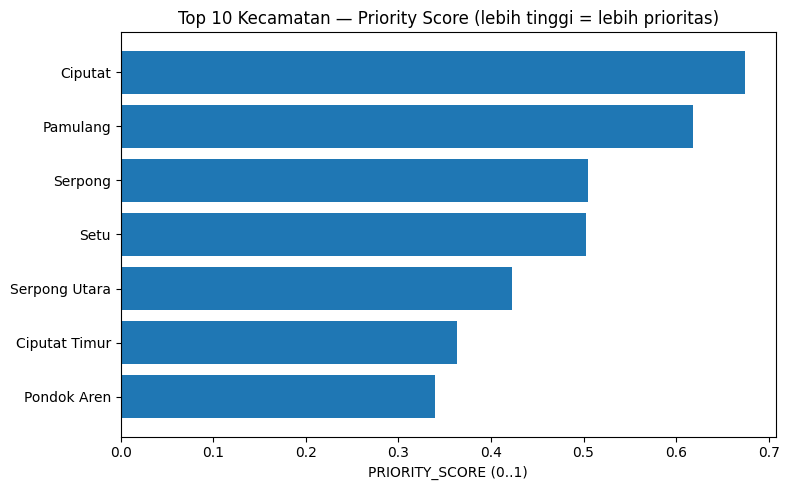

📝 Caption (Granite):
 📊 Caption: TOP 10 Kecamatan dengan Prioritas Terkemuka

Pola umum: Kecamatan Ciputat dan Pamulang memiliki skor prioritas tertinggi, terutama karena tingginya risiko stunting. Kecamatan Serpong dan Setu juga memiliki skor prioritas yang tinggi, dengan risiko ASi dan layanan kesehatan yang meningkat. Kecamatan lainnya, seperti Serpong Utara, Ciputat Timur, dan Pondok Aren, juga memiliki skor prioritas yang signifikan, terkait dengan risiko imunisasi, stunting, ASi, layanan, dan gizi karyawan.

Rekomendasi:
1. Fokus penanganan terhadap kecamatan dengan skor prioritas tinggi, terutama Ciputat dan Pamulang, untuk mengurangi risiko stunting.
2. Memperhatikan kecamatan lainnya, seperti Serpong, Setu, Serpong Utara, Ciputat Timur, dan Pondok Aren, untuk mengembangkan strategi yang spesifik terhadap risiko imunisasi, ASi, layanan, dan gizi karyawan.


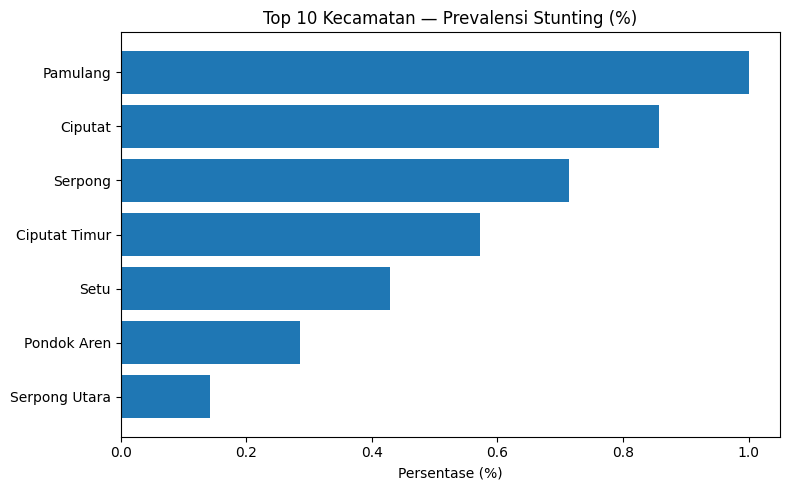

📝 Caption (Granite):
 📊 Stunting Rates in South Jakarta: A Health Analyst's Perspective 📊

🔍 Top 3 High-Risk Kecamatan:
1. Pamulang: 100% stunting risk
2. Ciputat: 85.71% stunting risk
3. Serpong: 71.43% stunting risk

🚨 Urgent Policy Interventions Needed:
- Pamulang requires immediate, comprehensive nutrition programs and healthcare access improvements.
- Ciputat and Serpong necessitate targeted interventions focusing on early childhood nutrition and parental education.

📈 Let's work together to reduce stunting rates and ensure healthy growth for all children in these areas. #HealthForAll #EndStunting #ChildNutrition


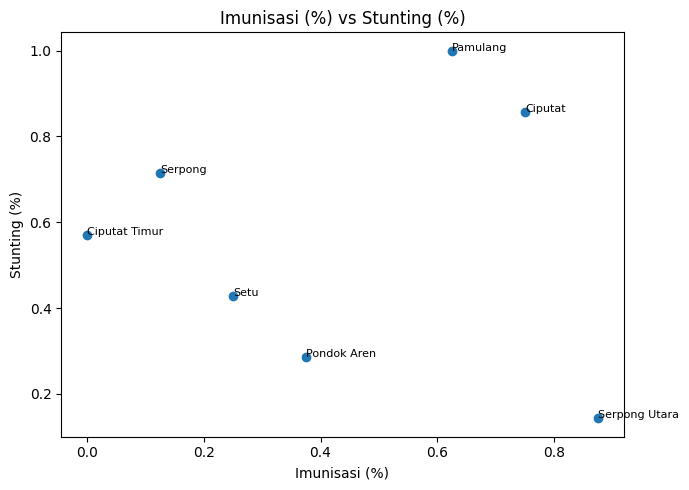

📝 Caption (Granite):
 Scatter plot dari data imunisasi dan stunting menunjukkan hubungan yang tidak kuat dan tidak teratur. Imunisasi (%) tidak berkaitan langsung dengan stunting (%), karena titik data bervariasi tanpa pola yang kuat. Namun, beberapa titik terlihat di bawah kurva, suggerekan hubungan negatif potensial, berarti imunisasi tinggi dapat menurunkan stunting.

Rekomendasi operasional: **Lakukan program imunisasi yang lebih intensif di daerah-daerah dengan tingkat stunting tinggi**. Pengembangan strategi kesehatan masyarakat yang holistik, meliputi peningkatan akses ke vaksinasi, pendidikan kesehatan, dan perluasan sarpras Misaki, dapat membantu mengurangi stunting.

Selesai. Jika butuh export PNG, jalankan: plt.savefig('nama_file.png') setelah tiap chart.


In [ ]:

import os, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#) Persiapan Replicate/Granite
try:
    import replicate
except ModuleNotFoundError:
    !pip -q install -U replicate
    import replicate

if not os.environ.get("REPLICATE_API_TOKEN"):
    print("⚠️ REPLICATE_API_TOKEN belum terpasang (Colab Secrets). Caption AI akan dilewati.")

def granite(prompt, max_new_tokens=220, temperature=0.25):
    try:
        out = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={"prompt": prompt, "max_new_tokens": max_new_tokens, "temperature": temperature}
        )
        return "".join(out)
    except Exception as e:
        return f"(Granite tidak tersedia: {e})"

# 1) Load data
master_path = "/content/master_dataset_clean.csv"
rank_path   = "/content/priority_ranking.csv"
assert os.path.exists(master_path), "master_dataset_clean.csv tidak ditemukan."
df = pd.read_csv(master_path)

if os.path.exists(rank_path):
    rank = pd.read_csv(rank_path)
else:
    # fallback sederhana: kalau tidak ada ranking, pakai stunting untuk urutan awal
    cand = [c for c in df.columns if re.search(r"(stunting|prevalen)", c, re.I)]
    st_col = cand[0] if cand else None
    if st_col is None:
        raise ValueError("Tidak bisa membuat ranking fallback: kolom stunting tidak ditemukan.")
    s = pd.to_numeric(df[st_col], errors="coerce")
    rank = pd.DataFrame({"Kecamatan": df["Kecamatan"], "PRIORITY_SCORE": (s - s.min())/(s.max()-s.min())})

# 2) Deteksi kolom penting dari master (agar chart spesifik indikatornya)
def pct_ratio(s):
    x = pd.to_numeric(s, errors="coerce").dropna()
    return 0 if x.empty else x.between(0,100).mean()

def pick_col(regex_list):
    cands = []
    for rgx in regex_list:
        cands += [c for c in df.columns if re.search(rgx, c, re.I)]
    # ambil yang terlihat seperti persen
    cands = [c for c in cands if pct_ratio(df[c]) >= 0.6]
    if not cands:
        return None
    # pilih median terendah (umumnya persen)
    meds = {c: pd.to_numeric(df[c], errors="coerce").median(skipna=True) for c in cands}
    return min(meds, key=meds.get)

col_stunting  = pick_col([r"stunting|prevalen"])
col_imunisasi = pick_col([r"imunisasi|dasar_lengkap|anak.?12|12[_\- ]?23"])
col_asi       = pick_col([r"\basi\b|kurang.*6.*bulan|bayi.*6"])

# 3) Chart 1 — TOP 10 PRIORITY_SCORE
import re

# hapus baris agregat/artefak
EXCLUDE = re.compile(r'^(total|jumlah|kecamatan|skor|score)$', re.I)
rank_clean = rank.copy()
rank_clean["Kecamatan"] = rank_clean["Kecamatan"].astype(str).str.strip()
rank_clean = rank_clean[~rank_clean["Kecamatan"].str.lower().str.match(EXCLUDE)]

# plot Top 10 setelah dibersihkan
topN = 10
top_priority = rank_clean.sort_values("PRIORITY_SCORE", ascending=False).head(topN)

plt.figure(figsize=(8,5))
plt.barh(top_priority["Kecamatan"], top_priority["PRIORITY_SCORE"])
plt.gca().invert_yaxis()
plt.title("Top 10 Kecamatan — Priority Score (lebih tinggi = lebih prioritas)")
plt.xlabel("PRIORITY_SCORE (0..1)")
plt.tight_layout()
plt.show()


# Caption AI untuk Chart 1
if os.environ.get("REPLICATE_API_TOKEN"):
    payload = top_priority.to_dict(orient="records")
    prompt = f"""
Anda adalah analis kesehatan. Buat caption ringkas (≤80 kata, Bahasa Indonesia)
untuk grafik TOP 10 PRIORITY_SCORE berikut. Jelaskan pola umum dan 1-2 rekomendasi singkat.
Data:
{json.dumps(payload, ensure_ascii=False)}
"""
    print("📝 Caption (Granite):\n", granite(prompt, max_new_tokens=120))
else:
    print("(Lewati caption AI — token tidak ada)")

# 4) Chart 2 — Stunting (Top 10)
if col_stunting and col_stunting in df.columns:
    s = pd.to_numeric(df[col_stunting], errors="coerce")
    st = df.loc[~s.isna(), ["Kecamatan", col_stunting]].sort_values(col_stunting, ascending=False).head(topN)
    plt.figure(figsize=(8,5))
    plt.barh(st["Kecamatan"], st[col_stunting])
    plt.gca().invert_yaxis()
    plt.title("Top 10 Kecamatan — Prevalensi Stunting (%)")
    plt.xlabel("Persentase (%)")
    plt.tight_layout()
    plt.show()

    if os.environ.get("REPLICATE_API_TOKEN"):
        payload = st.to_dict(orient="records")
        prompt = f"""
Anda adalah analis kesehatan. Buat caption ≤80 kata untuk grafik stunting (%).
Sebutkan 2-3 kecamatan teratas dan risiko kebijakan singkat.
Data:
{json.dumps(payload, ensure_ascii=False)}
"""
        print("📝 Caption (Granite):\n", granite(prompt, max_new_tokens=120))
else:
    print("⚠️ Kolom stunting tidak ditemukan untuk Chart 2.")

# 5) Chart 3 — Scatter: Imunisasi vs Stunting (fallback ke ASI jika imunisasi tidak ada)
x_col = col_imunisasi if col_imunisasi else col_asi
x_label = "Imunisasi (%)" if col_imunisasi else ("ASI Eksklusif (%)" if col_asi else None)

if x_col and col_stunting:
    x = pd.to_numeric(df[x_col], errors="coerce")
    y = pd.to_numeric(df[col_stunting], errors="coerce")
    valid = ~(x.isna() | y.isna())
    x, y, labels = x[valid], y[valid], df.loc[valid, "Kecamatan"]

    plt.figure(figsize=(7,5))
    plt.scatter(x, y)
    for xi, yi, lab in zip(x.head(10), y.head(10), labels.head(10)):
        plt.annotate(str(lab), (xi, yi), fontsize=8)
    plt.title(f"{x_label} vs Stunting (%)")
    plt.xlabel(x_label)
    plt.ylabel("Stunting (%)")
    plt.tight_layout()
    plt.show()

    if os.environ.get("REPLICATE_API_TOKEN"):
        sample = pd.DataFrame({x_label: x.head(10).tolist(), "Stunting(%)": y.head(10).tolist(), "Kecamatan": labels.head(10).tolist()})
        prompt = f"""
Anda adalah analis kesehatan. Jelaskan pola hubungan antara '{x_label}' dan 'Stunting (%)' pada scatter plot.
Gunakan Bahasa Indonesia, ≤90 kata, sertakan 1 rekomendasi operasional.
Sampel data (10 titik):
{json.dumps(sample.to_dict(orient="records"), ensure_ascii=False)}
"""
        print("📝 Caption (Granite):\n", granite(prompt, max_new_tokens=140))
else:
    print("⚠️ Tidak ditemukan pasangan indikator untuk scatter (butuh stunting dan imunisasi/ASI).")

print("\nSelesai. Jika butuh export PNG, jalankan: plt.savefig('nama_file.png') setelah tiap chart.")


In [ ]:
# === UI TANYA AI (IBM Granite via Replicate) ===
# Membuat kotak input untuk bertanya; opsional menyertakan fakta ringkas dataset.
import os, json, textwrap
import ipywidgets as widgets
from IPython.display import display, Markdown

# pastikan replicate terpasang
try:
    import replicate
except ModuleNotFoundError:
    !pip -q install -U replicate
    import replicate

TOKEN_OK = bool(os.environ.get("REPLICATE_API_TOKEN"))
if not TOKEN_OK:
    display(Markdown("**⚠️ REPLICATE_API_TOKEN belum terpasang di Colab Secrets.** (Sidebar 🔑 → Add `REPLICATE_API_TOKEN`)"))

facts_path = "/content/facts_for_ai.json"
facts = {}
if os.path.exists(facts_path):
    with open(facts_path, "r", encoding="utf-8") as f:
        facts = json.load(f)

# Widgets
ta = widgets.Textarea(
    value="Tolong jelaskan tiga prioritas intervensi dari data Tangsel 2022.",
    placeholder="Tulis pertanyaanmu di sini...",
    layout=widgets.Layout(width="100%", height="90px")
)
cb_facts = widgets.Checkbox(value=True, description="Sertakan fakta ringkas (facts_for_ai.json)")
temp = widgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.05, description="Temperature")
tokens = widgets.IntSlider(value=220, min=50, max=800, step=10, description="Max tokens")
btn = widgets.Button(description="Tanya Granite", button_style="primary")
out = widgets.Output()

def run_granite(_):
    out.clear_output()
    prompt = ta.value.strip()
    payload = ""
    if cb_facts.value and facts:
        payload = "\nFakta ringkas (jangan ubah angkanya):\n" + json.dumps(facts, ensure_ascii=False)
    sys = textwrap.dedent(f"""
    Anda adalah analis kesehatan publik. Jawab singkat, jelas, dan tidak menambah angka di luar data.
    Berikan saran operasional bila diminta. Bahasa: Indonesia.
    """).strip()

    full_prompt = f"{sys}\n\nPertanyaan:\n{prompt}\n{payload}\n"
    with out:
        if not TOKEN_OK:
            print("(Lewati — token Replicate belum tersedia.)")
            return
        try:
            resp = replicate.run(
                "ibm-granite/granite-3.3-8b-instruct",
                input={"prompt": full_prompt, "max_new_tokens": int(tokens.value), "temperature": float(temp.value)}
            )
            print("".join(resp))
        except Exception as e:
            print("Gagal memanggil Granite:", e)

btn.on_click(run_granite)

display(Markdown("### Tanya AI (Granite)"))
display(ta, cb_facts, temp, tokens, btn, out)


### Tanya AI (Granite)

Textarea(value='Tolong jelaskan tiga prioritas intervensi dari data Tangsel 2022.', layout=Layout(height='90px…

Checkbox(value=True, description='Sertakan fakta ringkas (facts_for_ai.json)')

FloatSlider(value=0.25, description='Temperature', max=1.0, step=0.05)

IntSlider(value=220, description='Max tokens', max=800, min=50, step=10)

Button(button_style='primary', description='Tanya Granite', style=ButtonStyle())

Output()